# Projection of velocities on simulation

In this notebook we illustrate the advantages of Nyström projection method to visualise velocities on a simulated dataset. Low-dimensional representation of velocity should preserve:
- the direction of the vectors 
- the magnitude (speed of change) of the vectors
- local variations (representing fluctuations of the dynamics & cell plasticities)

This notebook reproduces figures 1 and S6-S7. 

In [1]:
### load libraries

# general libraries
import numpy as np

# single cell libraries
import scvelo as scv

# plotting libraries
import matplotlib.pyplot as plt

# dimension reduction libraries
from sklearn.manifold import TSNE
import umap

In [2]:
%load_ext autoreload
%autoreload 2

import velocity
from simulation import *

# Generate simulation

We want to assess different aspects of velocity projection:

- how different visualisation methods capture regions with both high- and low variance and speed 
- how the methods could handle projecting new states to a space outside of the space observed in the original set

To show both of these aspects, we generated a simulation with high variance in root cell states, and faster velocities towards the end of the branch. The final state is not yet reached, and the velocities of the latest cells point towards not yet observed future states.

In [3]:
### set random seed
np.random.seed(3)

### set variables
n_vars, n_obs, t_max, noise_level = 25, 3000, 10, 1
switches = np.arange(.9, 0.999, (.999-.9)/n_vars)
start_t = None

### set parameters alpha, beta gamma
mu = np.array([1, .2, .05])
R = np.array([[1., .2, .2], 
              [.2, 1., .2], 
              [.2, .2, 1.]])
C = np.array([0.2, 0.2, 0.2])[:, None]
cov = C.dot(C.T) * R
alpha, beta, gamma = np.exp(np.random.multivariate_normal(mu, cov, size=n_vars).T)  # multivariate log-normal
beta /= 3
gamma /= 3

### scale genes to different time scales (kappa)
max_kappa = 15
min_kappa = 1
kappa = np.random.uniform(min_kappa, max_kappa, n_vars)
kappa[0:3]=1
alpha, beta, gamma, switches = alpha*kappa, beta*kappa, gamma*kappa, switches

### create simulation dataset
adata = simulation(n_obs=n_obs, t_max=t_max, n_vars=n_vars, noise_level=noise_level, alpha=alpha, beta=beta, gamma=gamma, switches=switches, start_t=start_t)

### remove first 150 cells
adata = adata[0:n_obs-150].copy()
scv.pp.neighbors(adata)

### recover true velocities
velocity.tl.fit.get_velocity(adata, key="true", normalise="std")

computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


### Visualisation of velocities 

After calculatio of the low-dimensional embedding using the spliced counts (adata.layers["spliced"]), we visualise the true velocities using Nyström projection and compare it to scVelo's approach. We compare the two approaches on:
1. PCA
2. t-SNE
3. diffusion map
4. UMAP

### 1. PCA 

These figures correspond to Figure 1A and 1B in the manuscript.

In [4]:
velocity.project.pca.pca_project(adata, n_pcs=10, use_raw=True, variance_mean_scale=False)

Calculating PCA.
Projecting future states.
Saving to annData object.


In [5]:
pca_data = adata.obsm["X_pca"]
v_pca = adata.obsm["velocity_pca"]

v_pca/=np.std(v_pca)*2

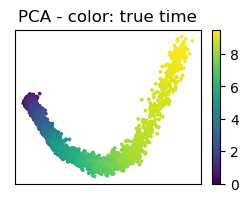

In [6]:
plt.subplots(1, 1, figsize=(3, 2))
plt.scatter(pca_data[:,0], pca_data[:,1], s=3, c=adata.obs["true_t"])
plt.xticks([]), plt.yticks([])
plt.title("PCA - color: true time")
plt.colorbar()
plt.show()

In [7]:
## scvelo projection approach
adata.obsm["X_pca"]=pca_data
bdata = adata.copy()
scv.tl.velocity_graph(bdata)
scv.tl.velocity_embedding(bdata, "pca")#, scale=0.10)
v_pca_scv = bdata.obsm["velocity_pca"][:,0:2]
v_pca_scv/=np.std(v_pca_scv)
v_pca_scv*=np.std(v_pca)

computing velocity graph
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


In [8]:
### select cells to highlight
idxfirst, step = 600, 5
sub = np.arange(idxfirst, adata.shape[0], 5) 

cell = pca_data[idxfirst+step*5]
dist = np.sum((pca_data[sub]-cell)**2, axis=1)
sub_slow = sub[np.argsort(dist)[0:45]] #sample cells at very beginning of trajectory

cell = pca_data[idxfirst+step*410]
dist = np.sum((pca_data[sub]-cell)**2, axis=1)
sub_fast = sub[np.argsort(dist)[0:20]] 

In [9]:
### set arguments for plotting
main_plot_aspect_ratio = (8, 6)
pltkwargs={"figsize":main_plot_aspect_ratio, "frameon":False}
akwargs = {"head_width":.2, "head_length":.2, "alpha":.6, "width":0.001, "color":"black"}
quiver_kwargs = {"scale": 1.5,"angles": "xy","scale_units": "xy","edgecolors": "k",
                #"linewidth": 0.02,"width": .003, 
                # "headwidth": 4, 
                # "headaxislength": 5,
                 "alpha":1,#.7
                }
(dim1, dim2) = (0, 1)
vecs = [v_pca, v_pca_scv]

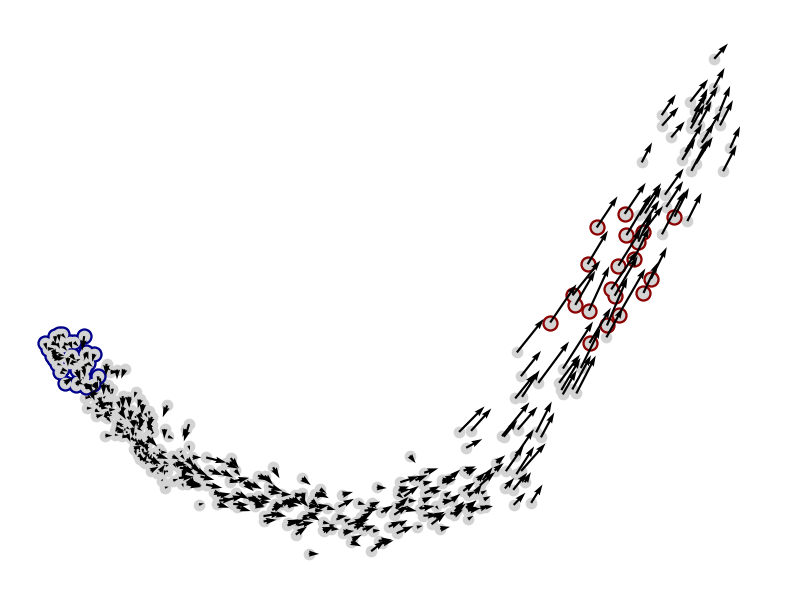

In [10]:
### create PCA plot (kappa-velo visualisation)
fig, ax = plt.subplots(1, 1, **pltkwargs)
for v_ in vecs: # this line is done s.t. the two plots have the exact same dimensions, even if the velocities are different
        ax.scatter(pca_data[sub,dim1]+v_pca[sub, dim1], pca_data[sub,dim2]+v_pca[sub, dim2], s=1, color="white")
ax.scatter(pca_data[sub,dim1], pca_data[sub,dim2], s=55, color="lightgrey")
ax.scatter(pca_data[sub_slow,dim1], pca_data[sub_slow,dim2], s=115, color="darkblue")
ax.scatter(pca_data[sub_slow,dim1], pca_data[sub_slow,dim2], s=55, color="lightgrey")
ax.scatter(pca_data[sub_fast,dim1], pca_data[sub_fast,dim2], s=115, color="darkred")
ax.scatter(pca_data[sub_fast,dim1], pca_data[sub_fast,dim2], s=55, color="lightgrey")
ax.axis("off")


ax.quiver(pca_data[sub,dim1], pca_data[sub,dim2], 
          v_pca[sub,dim1], v_pca[sub,dim2], **quiver_kwargs)

fig.tight_layout()

# save figure
save_path = "../figures/simulation/Fig2A_PCA_simulation_kappa-velo.png"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()

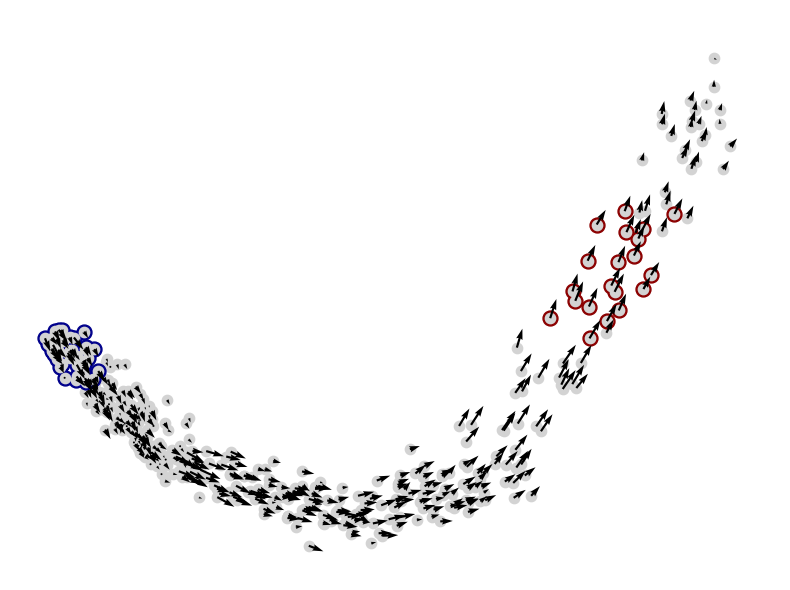

In [11]:
### create PCA plot (scVelo visualisation)
fig, ax = plt.subplots(1, 1, **pltkwargs)
for v_ in vecs:
        ax.scatter(pca_data[sub,dim1]+v_[sub, dim1], pca_data[sub,dim2]+v_[sub, dim2], s=1, color="white")
ax.scatter(pca_data[sub,dim1], pca_data[sub,dim2], s=55, color="lightgrey")
ax.scatter(pca_data[sub_slow,dim1], pca_data[sub_slow,dim2], s=115, color="darkblue")
ax.scatter(pca_data[sub_slow,dim1], pca_data[sub_slow,dim2], s=55, color="lightgrey")
ax.scatter(pca_data[sub_fast,dim1], pca_data[sub_fast,dim2], s=115, color="darkred")
ax.scatter(pca_data[sub_fast,dim1], pca_data[sub_fast,dim2], s=55, color="lightgrey")
ax.axis("off")

ax.quiver(pca_data[sub,dim1], pca_data[sub,dim2], 
          v_pca_scv[sub,dim1], v_pca_scv[sub,dim2], #color="darkred", 
             **quiver_kwargs)

fig.tight_layout()

# save figure
save_path = "../figures/simulation/Fig2B_PCA_simulation_scVelo.png"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()

#### supplementary figure nyström projection on PCA

In [12]:
bdata = adata.copy()
velocity.project.nystroem.nystroem_project(bdata, basis="pca", n_neighbors=15)
v_pca_nystroem = bdata.obsm["velocity_pca"]

v_pca_nystroem/=np.std(v_pca_nystroem)
v_pca_nystroem*=np.std(v_pca)

Scaling velocities down, set "force_no_scale=True" to stop this.
Projecting velocities using Nyström approach.
Saving to annData object.


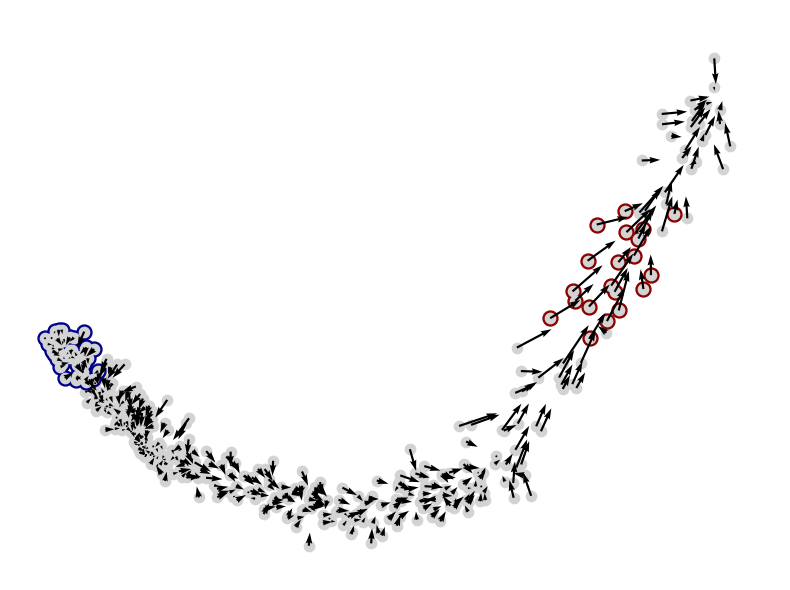

In [13]:
### create PCA plot (kappa-velo visualisation)
fig, ax = plt.subplots(1, 1, **pltkwargs)
for v_ in vecs: # this line is done s.t. the two plots have the exact same dimensions, even if the velocities are different
        ax.scatter(pca_data[sub,dim1]+v_[sub, dim1], pca_data[sub,dim2]+v_[sub, dim2], s=1, color="white")
ax.scatter(pca_data[sub,dim1], pca_data[sub,dim2], s=55, color="lightgrey")
ax.scatter(pca_data[sub_slow,dim1], pca_data[sub_slow,dim2], s=115, color="darkblue")
ax.scatter(pca_data[sub_slow,dim1], pca_data[sub_slow,dim2], s=55, color="lightgrey")
ax.scatter(pca_data[sub_fast,dim1], pca_data[sub_fast,dim2], s=115, color="darkred")
ax.scatter(pca_data[sub_fast,dim1], pca_data[sub_fast,dim2], s=55, color="lightgrey")
ax.axis("off")

ax.quiver(pca_data[sub,dim1], pca_data[sub,dim2], 
              v_pca_nystroem[sub,dim1], v_pca_nystroem[sub,dim2], **quiver_kwargs)

fig.tight_layout()

# save figure
save_path = "../figures/simulation/FigSX_PCA_simulation_nystrom.png"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()

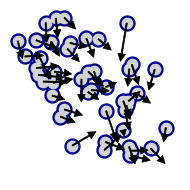

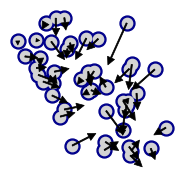

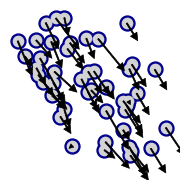

In [14]:
### create PCA plot (kappa-velo visualisation)
quiver_kwargs = {"scale": 1.5,"angles": "xy","scale_units": "xy","edgecolors": "k",
                "linewidth": .5,
                 "headwidth": 6, 
                 "headlength": 6, 
                 "headaxislength":6,
                # "alpha":1,#.7
                }

main_plot_aspect_ratio = (2, 2)
pltkwargs={"figsize":main_plot_aspect_ratio, "frameon":False}

fig, ax = plt.subplots(1, 1, **pltkwargs)
for v_ in vecs: # this line is done s.t. the two plots have the exact same dimensions, even if the velocities are different
        ax.scatter(pca_data[sub_slow,dim1]+v_pca[sub_slow, dim1], pca_data[sub_slow,dim2]+v_pca[sub_slow, dim2], s=1, color="white")
ax.scatter(pca_data[sub_slow,dim1], pca_data[sub_slow,dim2], s=115, color="darkblue")
ax.scatter(pca_data[sub_slow,dim1], pca_data[sub_slow,dim2], s=55, color="lightgrey")
ax.axis("off")


ax.quiver(pca_data[sub_slow,dim1], pca_data[sub_slow,dim2], 
          v_pca[sub_slow,dim1], v_pca[sub_slow,dim2], **quiver_kwargs)

fig.tight_layout()

# save figure
save_path = "../figures/simulation/Fig2A_PCA_simulation_kappa-velo_slow.png"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()


fig, ax = plt.subplots(1, 1, **pltkwargs)
for v_ in vecs: # this line is done s.t. the two plots have the exact same dimensions, even if the velocities are different
        ax.scatter(pca_data[sub_slow,dim1]+v_pca[sub_slow, dim1], pca_data[sub_slow,dim2]+v_pca[sub_slow, dim2], s=1, color="white")
ax.scatter(pca_data[sub_slow,dim1], pca_data[sub_slow,dim2], s=115, color="darkblue")
ax.scatter(pca_data[sub_slow,dim1], pca_data[sub_slow,dim2], s=55, color="lightgrey")
ax.axis("off")


ax.quiver(pca_data[sub_slow,dim1], pca_data[sub_slow,dim2], 
          v_pca_nystroem[sub_slow,dim1], v_pca_nystroem[sub_slow,dim2], **quiver_kwargs)

fig.tight_layout()

# save figure
save_path = "../figures/simulation/Fig2A_PCA_simulation_kappa-velo_slow_nystrom.png"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()



fig, ax = plt.subplots(1, 1, **pltkwargs)
for v_ in vecs: # this line is done s.t. the two plots have the exact same dimensions, even if the velocities are different
        ax.scatter(pca_data[sub_slow,dim1]+v_pca[sub_slow, dim1], pca_data[sub_slow,dim2]+v_pca[sub_slow, dim2], s=1, color="white")
ax.scatter(pca_data[sub_slow,dim1], pca_data[sub_slow,dim2], s=115, color="darkblue")
ax.scatter(pca_data[sub_slow,dim1], pca_data[sub_slow,dim2], s=55, color="lightgrey")
ax.axis("off")


ax.quiver(pca_data[sub_slow,dim1], pca_data[sub_slow,dim2], 
          v_pca_scv[sub_slow,dim1], v_pca_scv[sub_slow,dim2], **quiver_kwargs)

fig.tight_layout()

# save figure
save_path = "../figures/simulation/Fig2A_PCA_simulation_kappa-velo_slow_scvelo.png"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()

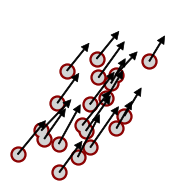

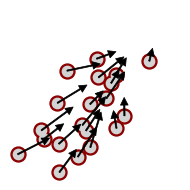

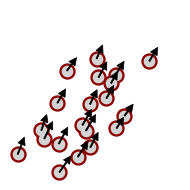

In [15]:
### create PCA plot (kappa-velo visualisation)
main_plot_aspect_ratio = (2, 2)
pltkwargs={"figsize":main_plot_aspect_ratio, "frameon":False}

fig, ax = plt.subplots(1, 1, **pltkwargs)
for v_ in vecs: # this line is done s.t. the two plots have the exact same dimensions, even if the velocities are different
        ax.scatter(pca_data[sub_fast,dim1]+v_pca[sub_fast, dim1], 
                   pca_data[sub_fast,dim2]+v_pca[sub_fast, dim2], s=1, color="white")
ax.scatter(pca_data[sub_fast,dim1], pca_data[sub_fast,dim2], s=115, color="darkred")
ax.scatter(pca_data[sub_fast,dim1], pca_data[sub_fast,dim2], s=55, color="lightgrey")
ax.axis("off")
ax.quiver(pca_data[sub_fast,dim1], pca_data[sub_fast,dim2], 
          v_pca[sub_fast,dim1], v_pca[sub_fast,dim2], **quiver_kwargs)
fig.tight_layout()

# save figure
save_path = "../figures/simulation/Fig2A_PCA_simulation_kappa-velo_fast.png"
plt.savefig(save_path, dpi=300, transparent=True)
plt.show()


fig, ax = plt.subplots(1, 1, **pltkwargs)
for v_ in vecs: # this line is done s.t. the two plots have the exact same dimensions, even if the velocities are different
        ax.scatter(pca_data[sub_fast,dim1]+v_pca[sub_fast, dim1], 
                   pca_data[sub_fast,dim2]+v_pca[sub_fast, dim2], s=1, color="white")
ax.scatter(pca_data[sub_fast,dim1], pca_data[sub_fast,dim2], s=115, color="darkred")
ax.scatter(pca_data[sub_fast,dim1], pca_data[sub_fast,dim2], s=55, color="lightgrey")
ax.axis("off")
ax.quiver(pca_data[sub_fast,dim1], pca_data[sub_fast,dim2], 
          v_pca_nystroem[sub_fast,dim1], v_pca_nystroem[sub_fast,dim2], **quiver_kwargs)
fig.tight_layout()

# save figure
save_path = "../figures/simulation/Fig2A_PCA_simulation_kappa-velo_fast_nystrom.png"
plt.savefig(save_path, dpi=300, transparent=True)
plt.show()



fig, ax = plt.subplots(1, 1, **pltkwargs)
for v_ in vecs: # this line is done s.t. the two plots have the exact same dimensions, even if the velocities are different
        ax.scatter(pca_data[sub_fast,dim1]+v_pca[sub_fast, dim1], 
                   pca_data[sub_fast,dim2]+v_pca[sub_fast, dim2], s=1, color="white")
ax.scatter(pca_data[sub_fast,dim1], pca_data[sub_fast,dim2], s=115, color="darkred")
ax.scatter(pca_data[sub_fast,dim1], pca_data[sub_fast,dim2], s=55, color="lightgrey")
ax.axis("off")
ax.quiver(pca_data[sub_fast,dim1], pca_data[sub_fast,dim2], 
          v_pca_scv[sub_fast,dim1], v_pca_scv[sub_fast,dim2], **quiver_kwargs)

fig.tight_layout()

# save figure
save_path = "../figures/simulation/Fig2A_PCA_simulation_kappa-velo_fast_scvelo.png"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()

### 2. t-SNE

These figures correspond to Figure 1D in the manuscript and Supplementary Figure S4A and S4B.

In [16]:
### set seed
tSNE_data = TSNE(n_components=2, random_state=3, perplexity=50).fit_transform(pca_data)
tSNE_data[:,1]=-tSNE_data[:,1]
adata.obsm["X_tsne"]=tSNE_data

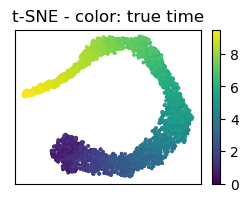

In [17]:
plt.subplots(1, 1, figsize=(3, 2))
plt.scatter(tSNE_data[:,0], tSNE_data[:,1], s=3, c=adata.obs["true_t"])
plt.xticks([]), plt.yticks([])
plt.title("t-SNE - color: true time")
plt.colorbar()
plt.show()

In [18]:
### calculate projection of velocities onto embedding (kappa-velo method)
velocity.project.nystroem.nystroem_project(adata, basis="tsne", n_neighbors=15)
v_tsne_nystroem = adata.obsm["velocity_tsne"]

v_tsne_nystroem/=np.std(v_tsne_nystroem)
v_tsne_nystroem*=np.std(v_tsne_nystroem)*2

Scaling velocities down, set "force_no_scale=True" to stop this.
Projecting velocities using Nyström approach.
Saving to annData object.


In [19]:
### calculate projection of velocities onto embedding (scVelo method)
bdata = adata.copy()
scv.tl.velocity_graph(bdata)
scv.tl.velocity_embedding(bdata, "tsne")
v_tsne_scvelo = bdata.obsm["velocity_tsne"][:,0:2] # velocities from scvelo

v_tsne_scvelo/=np.std(v_tsne_scvelo) # scale to same range for ease of comparison
v_tsne_scvelo*=np.std(v_tsne_nystroem)

computing velocity graph
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_tsne', embedded velocity vectors (adata.obsm)


In [20]:
### set arguments for plotting
quiver_kwargs = {"scale": 1,"angles": "xy","scale_units": "xy","edgecolors": "k",
                "linewidth": 0.02,"width": .003, 
                 "headwidth": 4, 
                 "headaxislength": 5,
                 "alpha":.9,#.7
                }
pltkwargs={"figsize":(6, 5), "frameon":False}
(dim1, dim2) = (0, 1)

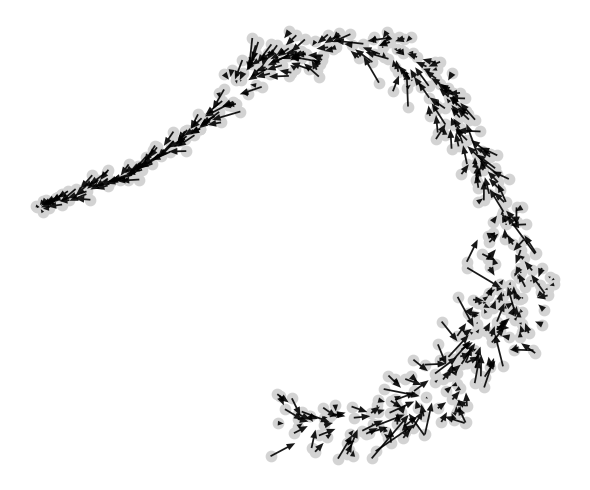

In [21]:
### create t-SNE plot (kappa-velo visualisation) 
fig, ax = plt.subplots(1, 1, **pltkwargs)

ax.scatter(tSNE_data[sub,dim1], tSNE_data[sub,dim2], s=55, color="lightgrey")
ax.axis("off")
ax.quiver(tSNE_data[sub,dim1], tSNE_data[sub,dim2], 
          v_tsne_nystroem[sub,dim1], v_tsne_nystroem[sub,dim2], **quiver_kwargs)
fig.tight_layout()

# save figure

save_path = "../figures/simulation/Fig2D_tSNE_nystroem.png"
plt.savefig(save_path, dpi=200, transparent=True)

plt.show()

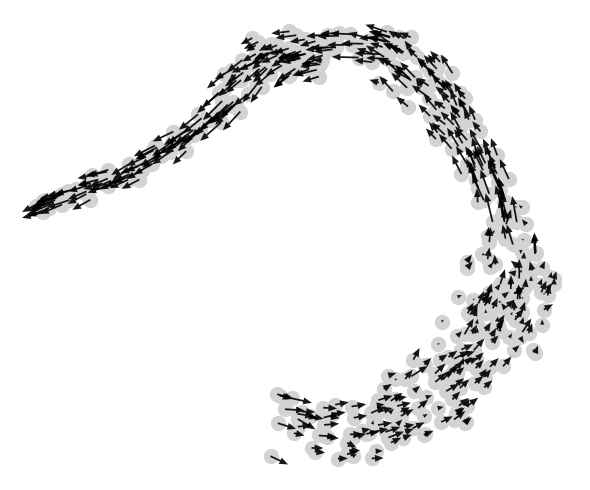

In [22]:
### create t-SNE plot (scVelo visualisation) 
fig, ax = plt.subplots(1, 1, **pltkwargs)
ax.scatter(tSNE_data[sub,dim1], tSNE_data[sub,dim2], s=100, color="lightgrey")
ax.axis("off")
ax.quiver(tSNE_data[sub,dim1], tSNE_data[sub,dim2], 
          v_tsne_scvelo[sub,dim1], v_tsne_scvelo[sub,dim2],
          **quiver_kwargs)
fig.tight_layout()

# save figure
save_path = "../figures/simulation/FigS6B_tSNE_scVelo.pdf"
plt.savefig(save_path, dpi=200, transparent=True)

plt.show()

### 3. diffusion map

These figures correspond to Figure S4C and S4D in the Supplementary Figures.

In [23]:
### calculate diffusion map embedding
sigma = 20
diffmap_data, diffmap_fut = velocity.project.nystroem.diffmap_and_project(pca_data, pca_data+v_pca, sigma=sigma)

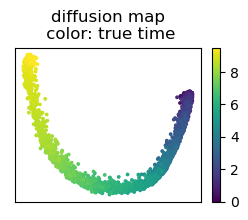

In [24]:
plt.subplots(1, 1, figsize=(3, 2))
plt.scatter(diffmap_data[:,1], diffmap_data[:,2], s=3, c=adata.obs["true_t"])
plt.xticks([]), plt.yticks([])
plt.title("diffusion map\n color: true time")
plt.colorbar()
plt.show()

In [25]:
v_diffmap_nystrom = diffmap_fut-diffmap_data

In [26]:
### calculate projection of velocities onto embedding (scVelo method)
adata.obsm["X_diffmap_own"]=diffmap_data
bdata = adata.copy()
scv.tl.velocity_graph(bdata)
scv.tl.velocity_embedding(bdata, "diffmap_own")
v_diffmap_scvelo = bdata.obsm["velocity_diffmap_own"]
v_diffmap_scvelo/=np.std(v_diffmap_scvelo[:,1:3])
v_diffmap_scvelo*=np.std(v_diffmap_nystrom[:,1:3])

computing velocity graph
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_diffmap_own', embedded velocity vectors (adata.obsm)


In [27]:
### set arguments for plotting
pltkwargs={"figsize":(8, 5), "frameon":False}
quiver_kwargs = {"scale": 2,"angles": "xy","scale_units": "xy","edgecolors": "k"}
(dim1, dim2) = (1, 2)

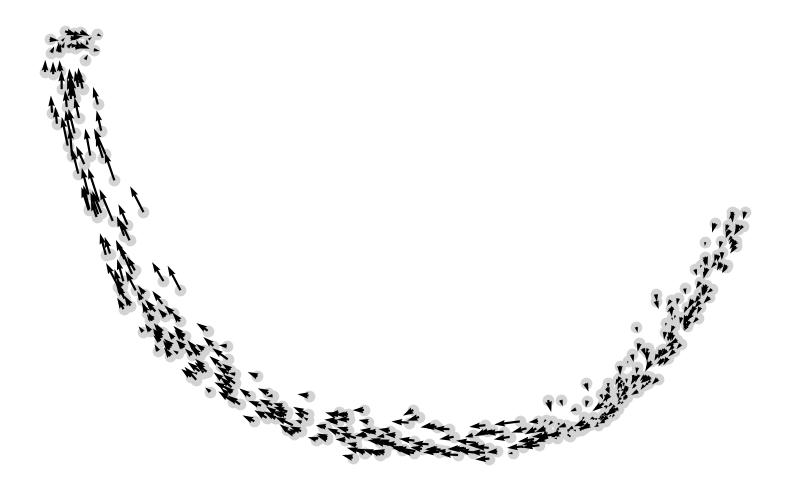

In [28]:
### create diffusion map plot (kappa-velo visualisation) 
fig, ax = plt.subplots(1, 1, **pltkwargs)

ax.scatter(diffmap_data[sub,dim1], diffmap_data[sub,dim2], s=55, color="lightgrey")
ax.axis("off")
ax.quiver(diffmap_data[sub,dim1], diffmap_data[sub,dim2], 
          v_diffmap_nystrom[sub,dim1], v_diffmap_nystrom[sub,dim2], **quiver_kwargs)
fig.tight_layout()

# save figure
save_path = "../figures/simulation/FigS7A_diffmap_nystroem.pdf"
plt.savefig(save_path, dpi=200, transparent=True)

plt.show()

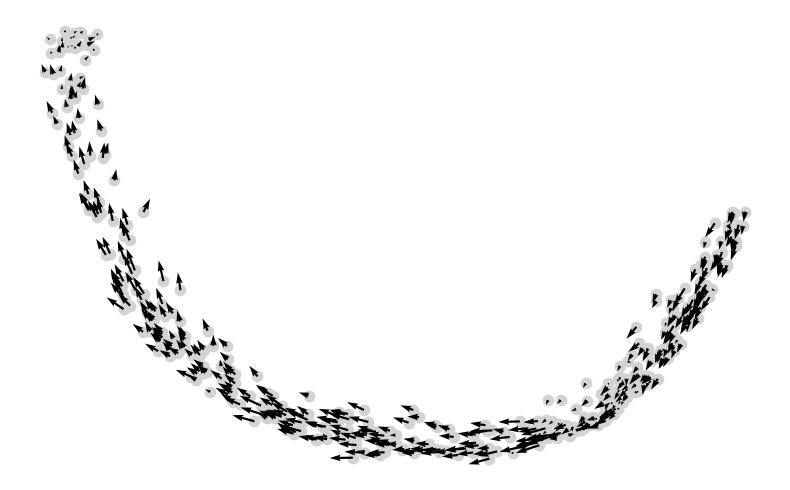

In [29]:
### create diffusion map plot (scVelo visualisation) 
fig, ax = plt.subplots(1, 1, **pltkwargs)
ax.scatter(diffmap_data[sub,dim1], diffmap_data[sub,dim2], s=55, color="lightgrey")
ax.axis("off")

ax.quiver(diffmap_data[sub,dim1], diffmap_data[sub,dim2], 
          v_diffmap_scvelo[sub,dim1], v_diffmap_scvelo[sub,dim2], **quiver_kwargs)

fig.tight_layout()

# save figure
save_path = "../figures/simulation/FigS7B_diffmap_scVelo.pdf"
plt.savefig(save_path, dpi=200, transparent=True)

plt.show()

### 4. UMAP
Figure S4E and S4F in Supplement.

In [30]:
reducer = umap.UMAP(random_state=2, n_neighbors=30, min_dist=1, n_components=2, metric="euclidean")
UMAP_data = reducer.fit_transform(pca_data)
adata.obsm["X_umap"]=UMAP_data

In [31]:
### calculate projection of velocities onto embedding (kappa-velo method)
velocity.project.nystroem.nystroem_project(adata, basis="umap", n_neighbors=15)
v_umap_nystrom = adata.obsm["velocity_umap"]

v_umap_nystrom/=np.std(v_umap_nystrom)
v_umap_nystrom*=np.std(v_umap_nystrom)

Scaling velocities down, set "force_no_scale=True" to stop this.
Projecting velocities using Nyström approach.
Saving to annData object.


In [32]:
### calculate projection of velocities onto embedding (scVelo method)
adata.obsm["X_umap"]=UMAP_data
bdata = adata.copy()
scv.tl.velocity_graph(bdata)
scv.tl.velocity_embedding(bdata, "umap")
v_umap_scvelo = bdata.obsm["velocity_umap"][:,0:2]
### calculate projection of velocities onto embedding (kappa-velo method)
v_umap_scvelo/=np.std(v_umap_scvelo)
v_umap_scvelo*=np.std(v_umap_nystrom)

computing velocity graph
    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


In [33]:
### set arguments for plotting
pltkwargs={"figsize":(6, 8), "frameon":False}
(dim1, dim2) = (0, 1)
quiver_kwargs={"scale": 2,"angles": "xy","scale_units": "xy"}

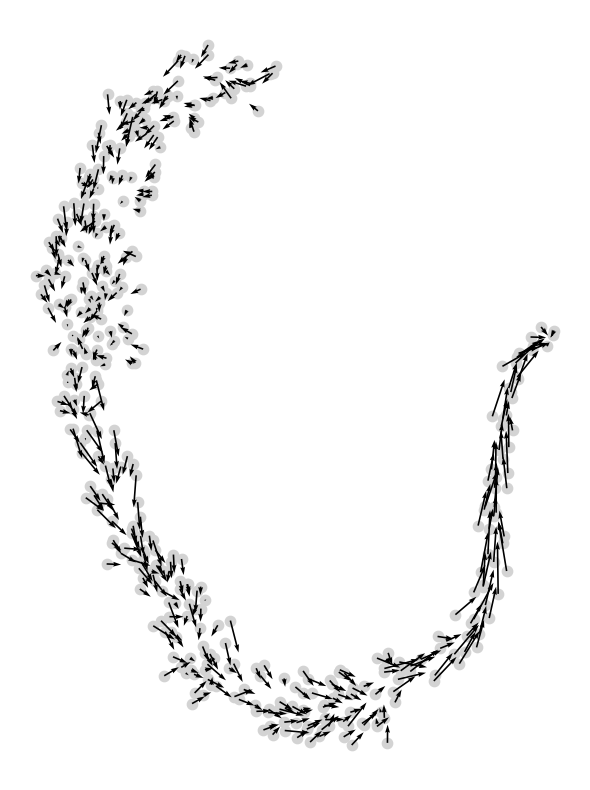

In [34]:
### create UMAP plot (kappa-velo visualisation) 
fig, ax = plt.subplots(1, 1, **pltkwargs)
ax.scatter(UMAP_data[sub,dim1], UMAP_data[sub,dim2], s=55, color="lightgrey")
ax.axis("off")
ax.quiver(UMAP_data[sub,dim1], UMAP_data[sub,dim2], 
          v_umap_nystrom[sub,dim1], v_umap_nystrom[sub,dim2], **quiver_kwargs)
fig.tight_layout()

# save figure
save_path = "../figures/simulation/FigS6C_UMAP_nystroem.pdf"
plt.savefig(save_path, dpi=200, transparent=True)

plt.show()

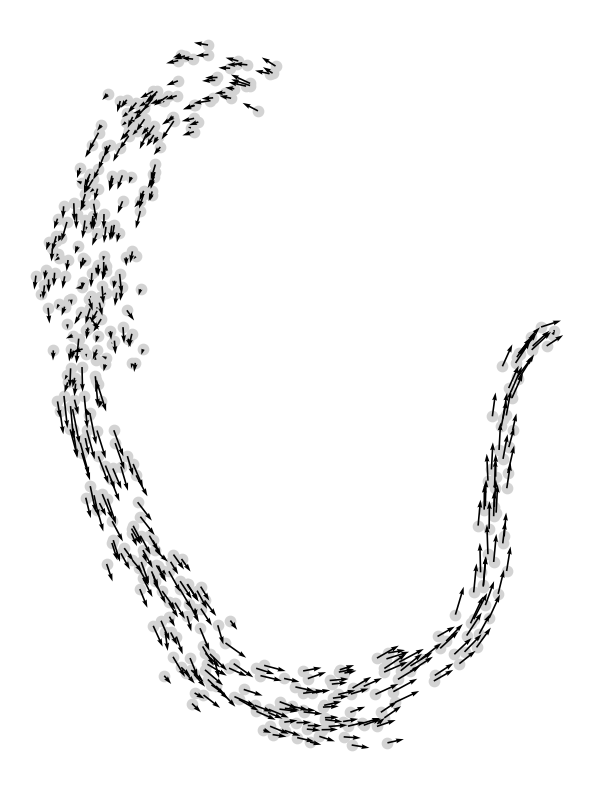

In [35]:
### create UMAP plot (scVelo visualisation) 
fig, ax = plt.subplots(1, 1, **pltkwargs)
ax.scatter(UMAP_data[sub,dim1], UMAP_data[sub,dim2], s=55, color="lightgrey")
ax.axis("off")
ax.quiver(UMAP_data[sub,dim1], UMAP_data[sub,dim2], 
          v_umap_scvelo[sub,dim1], v_umap_scvelo[sub,dim2], **quiver_kwargs)
fig.tight_layout()

# save figure
save_path = "../figures/simulation/FigS6D_UMAP_scVelo.pdf"
plt.savefig(save_path, dpi=200, transparent=True)

plt.show()